<a href="https://colab.research.google.com/github/SushantBharti/datasets/blob/master/Funinest_Covid_19_detection_using_chest_X_Ray_Model_developement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls /content/gdrive/My\ Drive/Google_Colab/

Chest_XRay_densenet.hdf5	HandsOnGoogleColabGPU.ipynb
Chest_XRay_pretrained_model.h5	mnist_cnn.py
Covid_19_data_zip.zip		Pneumonia_Detection
FLU_Prediction			Titanic.csv


In [0]:
import os
os.getcwd()

'/content'

In [0]:
! mkdir /content/covid_19

In [0]:
! unzip /content/gdrive/My\ Drive/Google_Colab/Covid_19_data_zip.zip -d /content/covid_19

In [0]:
!ls /content/covid_19/content/cloned-repo/Covid_19/training/

covid  non_covid


In [0]:
def get_train_generator(image_dir,shuffle=True, batch_size=16, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_directory(
            directory=image_dir,
            class_mode="binary",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [0]:
from keras.preprocessing.image import ImageDataGenerator
TRAINING_DIR = "/content/covid_19/content/cloned-repo/Covid_19/training/"
train_generator = get_train_generator(image_dir = TRAINING_DIR)


Using TensorFlow backend.


getting train generator...
Found 1694 images belonging to 2 classes.


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


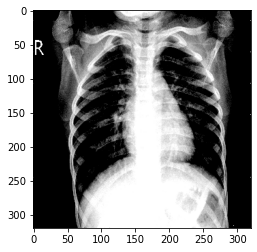

In [0]:
x, y = train_generator.__getitem__(7)
plt.imshow(x[0]);

In [0]:
def get_test_generator(image_dir_train,image_dir_test, sample_size=100, batch_size=16, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and test generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_directory(
        directory=image_dir_train,  
        class_mode="binary", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator

    test_generator = image_generator.flow_from_directory(
            directory=image_dir_test,
            class_mode="binary",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator

In [0]:
Test_DIR = "/content/covid_19/content/cloned-repo/Covid_19/testing/"
test_generator= get_test_generator(image_dir_train= TRAINING_DIR ,image_dir_test=Test_DIR)

getting train and test generators...
Found 1694 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [0]:
len(os.listdir("/content/covid_19/content/cloned-repo/Covid_19/testing/covid/"))

63

In [0]:
len(os.listdir("/content/covid_19/content/cloned-repo/Covid_19/testing/non_covid/"))

237

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


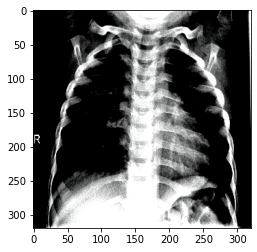

In [0]:
x, y = test_generator.__getitem__(8)
plt.imshow(x[0]);

**Model Development using DenseNet121**

We will use transfer learning by using weights trained by Pranav, Coursera Tutor AI 4 Medicine

In [0]:
!ls /content/gdrive/My\ Drive/Google_Colab/

Chest_XRay_densenet.hdf5	HandsOnGoogleColabGPU.ipynb
Chest_XRay_pretrained_model.h5	mnist_cnn.py
Covid_19_data_zip.zip		Pneumonia_Detection
FLU_Prediction			Titanic.csv


In [0]:
# create the base pre-trained model
base_model = DenseNet121(weights="/content/gdrive/My Drive/Google_Colab/Chest_XRay_densenet.hdf5", include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["binary_accuracy"])

In [0]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 15)

Epoch 1/15
100/100 [==============================] - 120s 1s/step - loss: 0.0969 - binary_accuracy: 0.9700 - val_loss: 471.3595 - val_binary_accuracy: 0.3232
Epoch 2/15
100/100 [==============================] - 70s 697ms/step - loss: 0.0343 - binary_accuracy: 0.9862 - val_loss: 8.3740e-04 - val_binary_accuracy: 0.9167
Epoch 3/15
100/100 [==============================] - 69s 692ms/step - loss: 0.0285 - binary_accuracy: 0.9875 - val_loss: 3.2973e-29 - val_binary_accuracy: 0.8939
Epoch 4/15
100/100 [==============================] - 70s 704ms/step - loss: 0.0287 - binary_accuracy: 0.9906 - val_loss: 3.0420e-06 - val_binary_accuracy: 0.9005
Epoch 5/15
100/100 [==============================] - 68s 680ms/step - loss: 0.0362 - binary_accuracy: 0.9850 - val_loss: 7.8096e-09 - val_binary_accuracy: 0.9293
Epoch 6/15
100/100 [==============================] - 68s 679ms/step - loss: 0.0289 - binary_accuracy: 0.9900 - val_loss: 3.3645e-10 - val_binary_accuracy: 0.9823
Epoch 7/15
100/100 [======

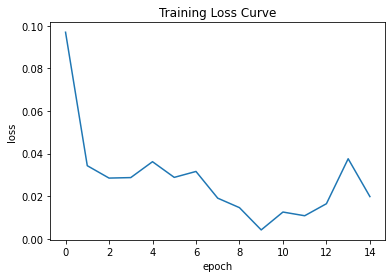

In [0]:
plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [0]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [0]:
predicted_vals

In [0]:
predicted_indices = (predicted_vals <= 0.5)* 1

In [0]:
np.unique(predicted_indices, return_counts=True)

(array([0, 1]), array([228,  72]))

In [0]:
type(filenames_1)

list

In [0]:
filenames_1 = np.array(filenames)

In [0]:
filenames[1]

'covid/0a7faa2a.jpg'

In [0]:
predicted_indices_1 = np.reshape(predicted_indices,(300,))

In [0]:
filenames=test_generator.filenames
filenames_1 = np.array(filenames)
results=pd.DataFrame({"Filename":filenames_1,
                      "Predictions":predicted_indices_1})

In [0]:
results.head()

,Filename,Predictions
0,covid/08d780ae.jpg,0
1,covid/0a7faa2a.jpg,0
2,covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg,1
3,covid/16630_2_1.jpg,1
4,covid/16630_4_1.jpg,1


In [0]:
results.to_csv("/content/gdrive/My Drive/Google_Colab/Baseline_Prediction_results.csv")

In [0]:
/content/gdrive/My\ Drive/Google_Colab/

In [0]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/Google_Colab/model_covid_19_Base_line_run_3June.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/Google_Colab/model_covid_19_Base_line_run_3June.h5")
print("Saved model to drive")

Saved model to drive


In [0]:
# load json and create model
from keras.models import model_from_json
json_file = open('/content/gdrive/My Drive/Google_Colab/model_covid_19_Base_line_run_3June.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/Google_Colab/model_covid_19_Base_line_run_3June.h5")
print("Loaded model from drive")

Loaded model from drive


In [0]:
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["binary_accuracy"])

In [0]:
predicted_vals_loaded_model = loaded_model.predict_generator(test_generator, steps = len(test_generator))

In [0]:
sum(predicted_vals_loaded_model==predicted_vals)

array([300])

In [0]:
sum(predicted_vals_loaded_model >= 0.99)

array([200])

<Figure size 432x288 with 0 Axes>

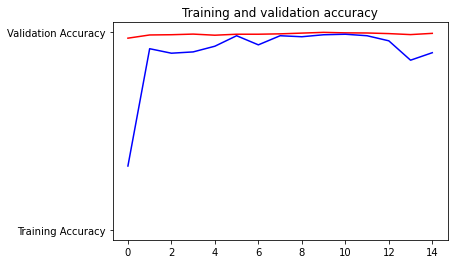

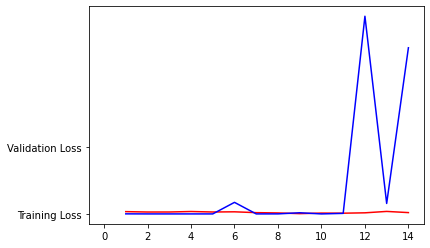

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['binary_accuracy']
val_acc=history.history['val_binary_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs[1:], loss[1:], 'r', "Training Loss")
plt.plot(epochs[1:], val_loss[1:], 'b', "Validation Loss")
plt.figure()

In [0]:
np.unique(predicted_vals <= 0.5,return_counts=True)

(array([False,  True]), array([228,  72]))

In [0]:
model.load_weights("/content/gdrive/My Drive/Google_Colab/Chest_XRay_pretrained_model.h5")

In [0]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

In [0]:
predicted_vals.argmax(axis= 1).shape

(300,)

In [0]:
np.unique(predicted_vals.argmax(axis= 1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([146,  10,   1,   1,  42,  32,  16,   2,   5,   2,   5,  17,  12,
          9]))